In [1]:
import numpy as np
import pandas as pd
import scipy

from IPython.display import clear_output

import sys
sys.path.append('../../../../Documents/GitHub/gustav/src/')

from gustav import ebi, ncbi, nlm, biogrid, nih, openalex
from gustav import publications
from gustav import github
from gustav import access_framework
from gustav import mapper

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../general/src/')
from manuscript import export
from manuscript import inout
from manuscript import datasets
from manuscript import tools

from sklearn.metrics import auc
from scipy.stats import fisher_exact
pd.options.display.precision = 3
pd.options.display.expand_frame_repr = False
pd.options.display.max_columns = 20

import gc
import re
import json
from tqdm.auto import tqdm
from statsmodels.stats.multitest import multipletests

In [2]:
sources = openalex.sources()

In [53]:
%%time
works_df = openalex.works(dataset='main', columns=['doi', 'type', 'year'], filters={'year':list(range(2003, 2024))})

CPU times: total: 2min 48s
Wall time: 2min 52s


In [54]:
works_df['doi_link'] = works_df['doi']
works_df['doi'] = works_df['doi_link'].astype(str).apply(lambda x: x.split('https://doi.org/')[-1])

In [55]:
works_df = works_df[['doi', 'type', 'year']].copy()

In [56]:
works_df = works_df[works_df['doi'].astype(str).str.startswith('10.1109')].copy()

In [57]:
ieee_works = works_df['doi'].values

In [58]:
ieee_works = ['https://doi.org/' + x for x in ieee_works]

In [59]:
%%time
works_df = openalex.works(dataset='main',  filters={'doi':ieee_works})

CPU times: total: 26min 2s
Wall time: 26min 13s


In [60]:
works_df.to_csv('../data/240325_ieee_works.csv', index=False)

# Run from here for figs:

In [2]:
sources = openalex.sources()

In [3]:
works_df = pd.read_csv('../data/240325_ieee_works.csv')

C:\Users\richa\AppData\Local\Temp\ipykernel_17912\3091254111.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  works_df = pd.read_csv('../data/240325_ieee_works.csv')


In [4]:
works_df[works_df['source_id'].astype(str) == 'None']

,work_id,source_id,doi,year,title,type,is_retracted,pubmed_id,pmc_id


In [5]:
works_df[works_df['type'] == 'proceedings-article']['source_id'].value_counts()

S4306419201    28661
S4306419991    27446
S4306419087    24365
S4306419084    21696
S4306418043    18825
               ...  
S4306514026        1
S4306495853        1
S4306419532        1
S4306422147        1
S2764569393        1
Name: source_id, Length: 4038, dtype: int64

In [6]:
works_df[works_df['source_id'].astype(str).str.lower().isin(['nan', 'none'])]

,work_id,source_id,doi,year,title,type,is_retracted,pubmed_id,pmc_id
0,W4200604589,NaN,https://doi.org/10.1109/isttca53489.2021.9654483,2021.0,Author Index,proceedings-article,False,3.494e+07,NaN
1,W4233205311,NaN,https://doi.org/10.1109/embc.2015.7318241,2015.0,Keynotes,proceedings-article,False,2.674e+07,NaN
2,W4254923350,NaN,https://doi.org/10.1109/embc.2017.8036742,2017.0,Workshops and tutorials,proceedings-article,False,2.906e+07,NaN
3,W4229514017,NaN,https://doi.org/10.1109/embc.2015.7318242,2015.0,Tutorials and workshops,proceedings-article,False,2.856e+07,NaN
4,W4251844200,NaN,https://doi.org/10.1109/embc.2018.8512235,2018.0,EMBC 2018 Keynote & Plenary Speakers,proceedings-article,False,3.044e+07,NaN
...,...,...,...,...,...,...,...,...,...
4213090,W2911710959,NaN,https://doi.org/10.1109/icicos.2018.8621642,2018.0,Neural Network Implementation of Divers Sign L...,proceedings-article,False,NaN,NaN
4213091,W4213145268,NaN,https://doi.org/10.1109/cic52973.2021.00010,2021.0,Conference Panel: Pandemic 2023 – An Informati...,proceedings-article,False,NaN,NaN
4213094,W4246375149,NaN,https://doi.org/10.1109/wi-iat.2012.305,2012.0,2012 Combined Workshop on Cross-Cultural and C...,proceedings-article,False,NaN,NaN
4213098,W4210881458,NaN,https://doi.org/10.1109/radar.2008.4721137,2008.0,Social events,proceedings-article,False,NaN,NaN


In [7]:
sources[sources['source_id'] == 'S4306419201']

,source_id,display_name,type,abbreviated_title,issn,issn_l,works_count,cited_by_count,country_code,homepage_url,host_organization_id,host_organization_name,alternate_titles
120984,S4306419201,International Conference on Communications,conference,None,None,None,37289,314443,None,None,None,None,None


In [8]:
works_df['suffix'] = works_df['doi'].apply(lambda x: x.split('10.1109/')[-1])

In [9]:
works_df[works_df['type'] == 'proceedings']['suffix'].value_counts()

radar42522.2020        2
icrms55680.2022        1
rws55399.2022          1
iwbis56557.2022        1
fie56618.2022          1
                      ..
cimsim19649.2011       1
nap51885.2021          1
iwobi47054.2019        1
scam.2003              1
icse-seis52602.2021    1
Name: suffix, Length: 23365, dtype: int64

In [10]:
proc_suffix = works_df[works_df['type'] == 'proceedings']['suffix'].unique()

In [11]:
len(works_df[works_df['suffix'].str.startswith(proc_suffix[0])])

194

In [12]:
conf_dict = {}
for suffix in proc_suffix:
    conf_dict[suffix] = suffix
    new_suffix = suffix.split('.')[0].rstrip('1234567890') + '.' + suffix.split('.')[-1]
    conf_dict[new_suffix] = suffix
    
def get_conf(suffix):
    try:
        suffix = '.'.join(suffix.split('.')[0:2])
        return conf_dict.get(suffix)
    except:
        return None

In [13]:
works_df['conference'] = works_df['suffix'].apply(get_conf)

In [14]:
works_df_slice = works_df[works_df['type'] == 'proceedings-article']

In [15]:
works_df_slice = works_df_slice[~works_df_slice['conference'].isna()]#['title']

In [16]:
prohib_title = works_df_slice['title'].value_counts()[works_df_slice['title'].value_counts() > 1].index.values

In [17]:
works_df_slice = works_df_slice[~(works_df_slice['title'].isin(prohib_title) | \
                                  works_df_slice['title'].str.lower().str.contains('keynote') | \
                                  works_df_slice['title'].str.lower().str.contains('plenary') |
                                 works_df_slice['title'].str.lower().str.contains('workshop') | 
                                  works_df_slice['title'].str.lower().str.contains('conference') | 
                                  works_df_slice['title'].str.lower().str.contains('chairs'))]

In [18]:
works_df_slice['conference'].value_counts().head(np.random.choice(range(16_600))).tail(1)

cicc.2004    179
Name: conference, dtype: int64

In [19]:
works_df_slice['conf_year'] = works_df_slice['conference'].apply(lambda x: x.split('.')[-1])

In [20]:
tort_df = pd.read_csv('../data/240321_tortured_phrases.csv')

In [21]:
# sometimes the IEEE DOI is listed as the RetractionDOI in the rw_db

rw_db = pd.read_csv('../data/240304_retraction_watch_db.csv', encoding='latin')
a = rw_db[rw_db['RetractionNature'] == 'Retraction']['OriginalPaperDOI'].values
a = [str(x).lower() for x in a]
c = rw_db[rw_db['RetractionNature'] == 'Retraction']['RetractionDOI'].values
c = [str(x).lower() for x in c]
a = list(set(a) | set(c))
#a = rw_db['OriginalPaperDOI'].values

In [24]:
pubpeer_df = pd.read_csv('C:/Users/richa/OneDrive - Northwestern University/pubpeer_comments_20240201.csv')
pubpeer_df['id'] = pubpeer_df['ids'].astype(str).apply(lambda x: x.split(','))
pubpeer_df = pubpeer_df.explode('id')
pubpeer_df['paper_link'] = pubpeer_df['Pubpeer Link'].astype(str).apply(lambda x: '/'.join(x.split('/')[:-1])).values
b = pubpeer_df['id'].values
b = [x.lower() for x in b]

C:\Users\richa\AppData\Local\Temp\ipykernel_35712\4220969110.py:1: DtypeWarning: Columns (1,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  pubpeer_df = pd.read_csv('C:/Users/richa/OneDrive - Northwestern University/pubpeer_comments_20240201.csv')


In [25]:
works_df_slice['doi'] = works_df_slice['doi'].apply(lambda x: x.split('https://doi.org/')[-1])

In [26]:
works_df_slice['retracted'] = works_df_slice['doi'].str.lower().isin(a)
works_df_slice['pubpeer'] = works_df_slice['doi'].isin(b)
works_df_slice['either'] = works_df_slice['retracted'] | works_df_slice['pubpeer']
works_df_slice['tortured'] = works_df_slice['doi'].isin(tort_df['DOI'].str.lower().values)
works_df_slice['total'] = True

In [27]:
works_df_slice = works_df_slice.copy()

In [28]:
works_df_slice[['retracted', 'pubpeer', 'either', 'tortured']].sum()

retracted    7763
pubpeer      2234
either       9979
tortured     2535
dtype: int64

In [29]:
editors_df = works_df_slice.copy()

In [30]:
"""
Created on Tue Mar 29, 2016

Module:
    poibin - Poisson Binomial Distribution

Author:
    Mika Straka

Description:
    Implementation of the Poisson Binomial distribution for the sum of
    independent and not identically distributed random variables as described
    in the reference [Hong2013]_.

    Implemented method:

        * ``pmf``: probability mass function
        * ``cdf``: cumulative distribution function
        * ``pval``: p-value (1 - cdf)

Usage:
    Be ``p`` a list or  NumPy array of success probabilities for ``n``
    non-identically distributed Bernoulli random variables.

    Import the module and create an instance of the distribution with::

        >>> from poibin import PoiBin
        >>> pb = PoiBin(p)

    Be ``x`` a list or NumPy array of different number of successes.
    To obtain the:

    * probability mass function of x, use::

        >>> pb.pmf(x)

    * cumulative distribution function of x, use::

        >>> pb.cdf(x)

    * p-values of x, use::

        >>> pb.pval(x)

    The functions are applied component-wise and a NumPy array of the same
    length as ``x`` is returned.

References:
.. [Hong2013] Yili Hong, On computing the distribution function for the Poisson
    binomial distribution,
    Computational Statistics & Data Analysis, Volume 59, March 2013,
    Pages 41-51, ISSN 0167-9473,
    http://dx.doi.org/10.1016/j.csda.2012.10.006.
"""

import collections
import numpy as np


class PoiBin(object):
    """Poisson Binomial distribution for random variables.

    This class implements the Poisson Binomial distribution for Bernoulli
    trials with different success probabilities. The distribution describes
    thus a random variable that is the sum of independent and not identically
    distributed single Bernoulli random variables.

    The class offers methods for calculating the probability mass function, the
    cumulative distribution function, and p-values for right-sided testing.
    """

    def __init__(self, probabilities):
        """Initialize the class and calculate the ``pmf`` and ``cdf``.

        :param probabilities: sequence of success probabilities :math:`p_i \\in
            [0, 1] \\forall i \\in [0, N]` for :math:`N` independent but not
            identically distributed Bernoulli random variables
        :type probabilities: numpy.array
        """
        self.success_probabilities = np.array(probabilities)
        self.number_trials = self.success_probabilities.size
        self.check_input_prob()
        self.omega = 2 * np.pi / (self.number_trials + 1)
        self.pmf_list = self.get_pmf_xi()
        self.cdf_list = self.get_cdf(self.pmf_list)

# ------------------------------------------------------------------------------
# Methods for the Poisson Binomial Distribution
# ------------------------------------------------------------------------------

    def pmf(self, number_successes):
        """Calculate the probability mass function ``pmf`` for the input values.

        The ``pmf`` is defined as

        .. math::

            pmf(k) = Pr(X = k), k = 0, 1, ..., n.

        :param number_successes: number of successful trials for which the
            probability mass function is calculated
        :type number_successes: int or list of integers
        """
        self.check_rv_input(number_successes)
        return self.pmf_list[number_successes]

    def cdf(self, number_successes):
        """Calculate the cumulative distribution function for the input values.

        The cumulative distribution function ``cdf`` for a number ``k`` of
        successes is defined as

        .. math::

            cdf(k) = Pr(X \\leq k), k = 0, 1, ..., n.

        :param number_successes: number of successful trials for which the
            cumulative distribution function is calculated
        :type number_successes: int or list of integers
        """
        self.check_rv_input(number_successes)
        return self.cdf_list[number_successes]

    def pval(self, number_successes):
        """Return the p-values corresponding to the input numbers of successes.

        The p-values for right-sided testing are defined as

        .. math::

            pval(k) = Pr(X \\geq k ),  k = 0, 1, ..., n.

        .. note::

            Since :math:`cdf(k) = Pr(X <= k)`, the function returns

            .. math::

                1 - cdf(X < k) & = 1 - cdf(X <= k - 1)
                               & = 1 - cdf(X <= k) + pmf(X = k),

                               k = 0, 1, .., n.

        :param number_successes: number of successful trials for which the
            p-value is calculated
        :type number_successes: int, numpy.array, or list of integers
        """
        self.check_rv_input(number_successes)
        i = 0
        try:
            isinstance(number_successes, collections.Iterable)
            pvalues = np.array(number_successes, dtype='float')
            # if input is iterable (list, numpy.array):
            for k in number_successes:
                pvalues[i] = 1. - self.cdf(k) + self.pmf(k)
                i += 1
            return pvalues
        except TypeError:
            # if input is an integer:
            if number_successes == 0:
                return 1
            else:
                return 1 - self.cdf(number_successes - 1)

# ------------------------------------------------------------------------------
# Methods to obtain pmf and cdf
# ------------------------------------------------------------------------------

    def get_cdf(self, event_probabilities):
        """Return the values of the cumulative density function.

        Return a list which contains all the values of the cumulative
        density function for :math:`i = 0, 1, ..., n`.

        :param event_probabilities: array of single event probabilities
        :type event_probabilities: numpy.array
        """
        cdf = np.empty(self.number_trials + 1)
        cdf[0] = event_probabilities[0]
        for i in range(1, self.number_trials + 1):
            cdf[i] = cdf[i - 1] + event_probabilities[i]
        return cdf

    def get_pmf_xi(self):
        """Return the values of the variable ``xi``.

        The components ``xi`` make up the probability mass function, i.e.
        :math:`\\xi(k) = pmf(k) = Pr(X = k)`.
        """
        chi = np.empty(self.number_trials + 1, dtype=complex)
        chi[0] = 1
        half_number_trials = int(
            self.number_trials / 2 + self.number_trials % 2)
        # set first half of chis:
        chi[1:half_number_trials + 1] = self.get_chi(
            np.arange(1, half_number_trials + 1))
        # set second half of chis:
        chi[half_number_trials + 1:self.number_trials + 1] = np.conjugate(
            chi[1:self.number_trials - half_number_trials + 1] [::-1])
        chi /= self.number_trials + 1
        xi = np.fft.fft(chi)
        if self.check_xi_are_real(xi):
            xi = xi.real
        else:
            raise TypeError("pmf / xi values have to be real.")
        xi += np.finfo(type(xi[0])).eps
        return xi

    def get_chi(self, idx_array):
        """Return the values of ``chi`` for the specified indices.

        :param idx_array: array of indices for which the ``chi`` values should
            be calculated
        :type idx_array: numpy.array
        """
        # get_z:
        exp_value = np.exp(self.omega * idx_array * 1j)
        xy = 1 - self.success_probabilities + \
            self.success_probabilities * exp_value[:, np.newaxis]
        # sum over the principal values of the arguments of z:
        argz_sum = np.arctan2(xy.imag, xy.real).sum(axis=1)
        # get d value:
        exparg = np.log(np.abs(xy)).sum(axis=1)
        d_value = np.exp(exparg)
        # get chi values:
        chi = d_value * np.exp(argz_sum * 1j)
        return chi

# ------------------------------------------------------------------------------
# Auxiliary functions
# ------------------------------------------------------------------------------

    def check_rv_input(self, number_successes):
        """Assert that the input values ``number_successes`` are OK.

        The input values ``number_successes`` for the random variable have to be
        integers, greater or equal to 0, and smaller or equal to the total
        number of trials ``self.number_trials``.

        :param number_successes: number of successful trials
        :type number_successes: int or list of integers """
        try:
            for k in number_successes:
                assert (type(k) == int or type(k) == np.int64), \
                        "Values in input list must be integers"
                assert k >= 0, 'Values in input list cannot be negative.'
                assert k <= self.number_trials, \
                    'Values in input list must be smaller or equal to the ' \
                    'number of input probabilities "n"'
        except TypeError:
            assert (type(number_successes) == int or \
                type(number_successes) == np.int64), \
                'Input value must be an integer.'
            assert number_successes >= 0, "Input value cannot be negative."
            assert number_successes <= self.number_trials, \
                'Input value cannot be greater than ' + str(self.number_trials)
        return True

    @staticmethod
    def check_xi_are_real(xi_values):
        """Check whether all the ``xi``s have imaginary part equal to 0.

        The probabilities :math:`\\xi(k) = pmf(k) = Pr(X = k)` have to be
        positive and must have imaginary part equal to zero.

        :param xi_values: single event probabilities
        :type xi_values: complex
        """
        return np.all(xi_values.imag <= np.finfo(float).eps)

    def check_input_prob(self):
        """Check that all the input probabilities are in the interval [0, 1]."""
        if self.success_probabilities.shape != (self.number_trials,):
            raise ValueError(
                "Input must be an one-dimensional array or a list.")
        if not np.all(self.success_probabilities >= 0):
            raise ValueError("Input probabilities have to be non negative.")
        if not np.all(self.success_probabilities <= 1):
            raise ValueError("Input probabilities have to be smaller than 1.")

################################################################################
# Main
################################################################################

if __name__ == "__main__":
    pass

In [31]:
rate_df = editors_df.groupby('conf_year').sum()[['retracted', 'pubpeer', 'either', 'tortured', 'total']]

rate_df['p_retracted'] = rate_df['retracted']/rate_df['total']
rate_df['p_pubpeer'] = rate_df['pubpeer']/rate_df['total']
rate_df['p_either'] = rate_df['either']/rate_df['total']
rate_df['p_tortured'] = rate_df['tortured']/rate_df['total']

In [32]:
rate_df

,retracted,pubpeer,either,tortured,total,p_retracted,p_pubpeer,p_either,p_tortured
conf_year,,,,,,,,,
1985,0,0,0,0,9,0.000e+00,0.000e+00,0.000e+00,0.000e+00
1991,0,0,0,0,82,0.000e+00,0.000e+00,0.000e+00,0.000e+00
1992,0,0,0,0,19,0.000e+00,0.000e+00,0.000e+00,0.000e+00
2002,0,0,0,0,59,0.000e+00,0.000e+00,0.000e+00,0.000e+00
2003,7,6,12,0,53616,1.306e-04,1.119e-04,2.238e-04,0.000e+00
2004,8,6,14,0,49474,1.617e-04,1.213e-04,2.830e-04,0.000e+00
2005,6,3,9,0,30656,1.957e-04,9.786e-05,2.936e-04,0.000e+00
2006,6,4,10,0,50966,1.177e-04,7.848e-05,1.962e-04,0.000e+00
2007,34,6,40,0,63080,5.390e-04,9.512e-05,6.341e-04,0.000e+00


In [33]:
summary_by_editor = editors_df.groupby('conference').sum()

In [34]:
editor_year_list = editors_df.groupby('conference')['conf_year'].apply(list)

In [35]:
%%time

# this one can be binomial since all the conferences happen in the same year
rate_dict = rate_df['p_retracted'].to_dict()
p_val_array = []
editor_list = []
for editor, row in tqdm(pd.DataFrame(editor_year_list).iterrows(), total=len(editor_year_list)):
    year_list = row['conf_year']
    p_array = [rate_dict.get(x) for x in year_list]
    prob = np.mean(p_array)
    p_val = PoiBin(p_array).pval(int(summary_by_editor.loc[editor]['retracted']))
    editor_list.append(editor)
    p_val_array.append(p_val)
    
p_val_df = pd.DataFrame({'editor':editor_list, 'retract_p_val':p_val_array})

rate_dict = rate_df['p_pubpeer'].to_dict()
p_val_array = []
editor_list = []
for editor, row in tqdm(pd.DataFrame(editor_year_list).iterrows(), total=len(editor_year_list)):
    year_list = row['conf_year']
    p_array = [rate_dict.get(x) for x in year_list]
    p_val = PoiBin(p_array).pval(int(summary_by_editor.loc[editor]['pubpeer']))
    editor_list.append(editor)
    p_val_array.append(p_val)

p_val_df['pubpeer_p_val'] = p_val_array

rate_dict = rate_df['p_either'].to_dict()
p_val_array = []
editor_list = []
for editor, row in tqdm(pd.DataFrame(editor_year_list).iterrows(), total=len(editor_year_list)):
    year_list = row['conf_year']
    p_array = [rate_dict.get(x) for x in year_list]
    p_val = PoiBin(p_array).pval(int(summary_by_editor.loc[editor]['either']))
    editor_list.append(editor)
    p_val_array.append(p_val)

p_val_df['either_p_val'] = p_val_array

rate_dict = rate_df['p_tortured'].to_dict()
p_val_array = []
editor_list = []
for editor, row in tqdm(pd.DataFrame(editor_year_list).iterrows(), total=len(editor_year_list)):
    year_list = row['conf_year']
    p_array = [rate_dict.get(x) for x in year_list]
    p_val = PoiBin(p_array).pval(int(summary_by_editor.loc[editor]['tortured']))
    editor_list.append(editor)
    p_val_array.append(p_val)

p_val_df['tortured_p_val'] = p_val_array

  0%|          | 0/19973 [00:00<?, ?it/s]

C:\Users\richa\AppData\Local\Temp\ipykernel_35712\1070855672.py:151: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  isinstance(number_successes, collections.Iterable)


  0%|          | 0/19973 [00:00<?, ?it/s]

  0%|          | 0/19973 [00:00<?, ?it/s]

  0%|          | 0/19973 [00:00<?, ?it/s]

CPU times: total: 1min 11s
Wall time: 1min 11s


In [36]:
p_val_df['year'] = p_val_df['editor'].apply(lambda x: int(x.split('.')[-1]))

In [37]:
p_val_df = p_val_df[p_val_df['year'] >= 2003].copy()

In [38]:
for col in ['retract_p_val', 'pubpeer_p_val', 'either_p_val', 'tortured_p_val']:
    p_val_df.loc[p_val_df[col] < 0, col] = 1e-17
    p_val_df[col.split('_')[0]+'_q_val'] = multipletests(p_val_df[col], method='fdr_bh')[1]
    p_val_df[col.split('_')[0]+'_fwer'] = multipletests(p_val_df[col], method='bonferroni')[1]

p_val_df = pd.merge(p_val_df, summary_by_editor.reset_index().rename(columns={'conference':'editor'}), on='editor')

In [39]:
len(p_val_df)

19969

In [42]:
p_val_df['total'].sum()

2294067

In [39]:
p_val_df = p_val_df.rename(columns={'editor':'conference'})

In [46]:
p_val_df.to_csv('../data/240320_ieee_conference_p_values.csv', index=False)

# Just make plots:

In [2]:
p_val_df = pd.read_csv('../data/240320_ieee_conference_p_values.csv')

In [3]:
p_val_df[(p_val_df['retracted']/p_val_df['total'] > 0.1)]['year_x'].value_counts()

2010    29
2011     9
2009     7
2018     1
2013     1
2012     1
Name: year_x, dtype: int64

In [4]:
p_val_df[(p_val_df['retracted'] > 10) & p_val_df['year_x'].isin([2009, 2010, 2011])]['retracted'].sum()

6902

In [5]:
p_val_df[p_val_df['retracted'] >= ]['year_x'].value_counts()

SyntaxError: invalid syntax (2871346916.py, line 1)

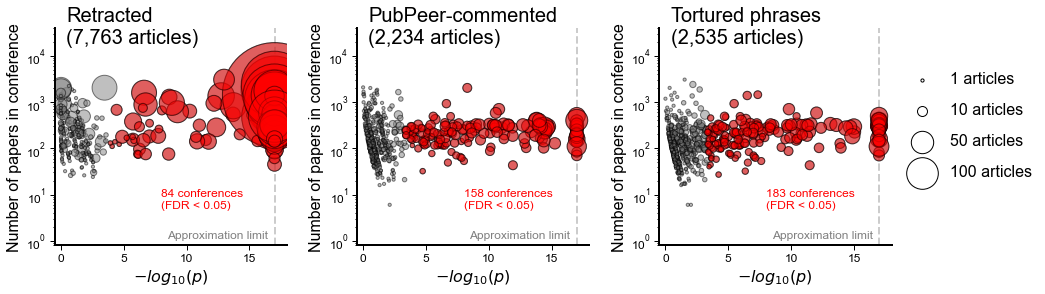

In [6]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15,4), gridspec_kw={'wspace':0.3})

# Retractions
ax = axes[0]
ax.scatter(-np.log10(p_val_df['retract_p_val']), p_val_df['total'],
           color='gray', linewidth=1, alpha=0.5, s=10*p_val_df['retracted'], edgecolor='k')
p_val_df_slice = p_val_df[p_val_df['retract_q_val'] < 0.05].copy()
ax.scatter(-np.log10(p_val_df_slice['retract_p_val']), p_val_df_slice['total'], 
           color='r', linewidth=1, alpha=0.5, s=10*p_val_df_slice['retracted'], edgecolor='k')
ax.set_title('Retracted\n(' + '{:,}'.format(p_val_df['retracted'].sum()) + ' articles)', fontsize=20, ha='left', x=0.05, y=0.9)
ax.text(s=str(len(p_val_df_slice)) + ' conferences\n(FDR < 0.05)', fontsize=12, y=5, x=8, color='r')

# PubPeer
ax = axes[1]
ax.scatter(-np.log10(p_val_df['pubpeer_p_val']), p_val_df['total'],
           color='gray', linewidth=1, alpha=0.5, s=10*p_val_df['pubpeer'], edgecolor='k')
p_val_df_slice = p_val_df[p_val_df['pubpeer_q_val'] < 0.05]
ax.scatter(-np.log10(p_val_df_slice['pubpeer_p_val']), p_val_df_slice['total'], 
           color='r', linewidth=1, alpha=0.5, s=10*p_val_df_slice['pubpeer'], edgecolor='k')
ax.set_title('PubPeer-commented\n(' + '{:,}'.format(p_val_df['pubpeer'].sum()) + ' articles)', fontsize=20, ha='left', x=0.05, y=0.9)
ax.text(s=str(len(p_val_df_slice)) + ' conferences\n(FDR < 0.05)', fontsize=12, y=5, x=8, color='r')

# Tortured
ax = axes[2]
ax.scatter(-np.log10(p_val_df['tortured_p_val']), p_val_df['total'],
           color='gray', linewidth=1, alpha=0.5, s=10*p_val_df['tortured'], edgecolor='k')
p_val_df_slice = p_val_df[p_val_df['tortured_q_val'] < 0.05]
ax.scatter(-np.log10(p_val_df_slice['tortured_p_val']), p_val_df_slice['total'],
           color='r', linewidth=1, alpha=0.5, s=10*p_val_df_slice['tortured'], edgecolor='k')
ax.set_title('Tortured phrases\n(' + '{:,}'.format(p_val_df['tortured'].sum()) + ' articles)',  fontsize=20, ha='left', x=0.05, y=0.9)
ax.text(s=str(len(p_val_df_slice)) + ' conferences\n(FDR < 0.05)', fontsize=12, y=5, x=8, color='r')

ax.scatter([], [], s=10, color='w', alpha=1, linewidth=1, edgecolor='k', label='1 articles')
ax.scatter([], [], s=100, color='w', alpha=1, linewidth=1, edgecolor='k', label='10 articles')
ax.scatter([], [], s=500, color='w', alpha=1, linewidth=1, edgecolor='k', label='50 articles')
ax.scatter([], [], s=1000, color='w', alpha=1, linewidth=1, edgecolor='k', label='100 articles')
#ax.scatter([], [], s=2000, color='w', alpha=1, linewidth=1, edgecolor='k', label='200 retracted/commented')
ax.legend(fontsize=16, bbox_to_anchor=(1,0.55), loc='center left', frameon=False, labelspacing=1, handletextpad=0.75)

for ax in axes:
    ax.set_yscale('log')
    ax.set_xlabel(r'$-log_{10}(p)$', fontsize=16)
    ax.set_ylabel('Number of papers in conference', fontsize=16)
    ax.set_ylim([0.8, 40_000])
    ax.set_xlim([-0.5,18])
    ax.tick_params(width=1, length=5, which='major')
    ax.tick_params(width=1, length=2, which='minor')
    ax.tick_params(labelsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    [ax.spines[i].set_linewidth(2) for i in ax.spines]
    ax.axvline(17, color='k', linewidth=2, linestyle='dashed', alpha=0.2, zorder=-10)
    ax.text(s='Approximation limit', x=16.5, y=1, fontsize=12, va='bottom', ha='right', color='k', alpha=0.5)
    
fig.savefig('../img/240320_ieee_p_value_axis_flip.png', dpi=200, bbox_inches='tight')

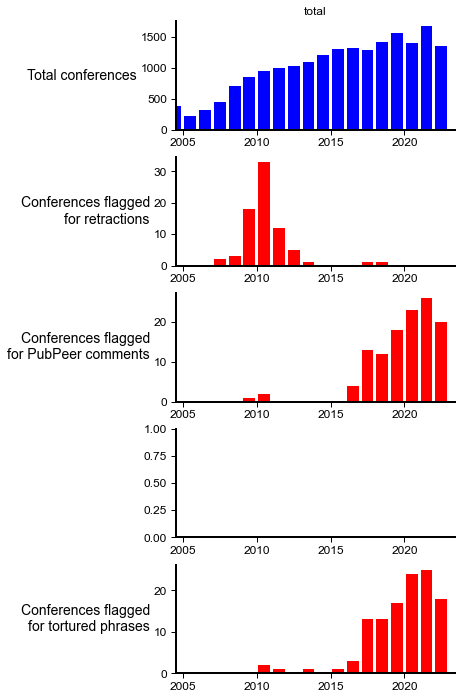

In [7]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(5,12),gridspec_kw={'hspace':0.25})

ax = axes[0]
data = p_val_df.groupby('year_x').count()['conference']
ax.bar(height=data, x=data.index+0.5, color='blue')
ax.set_title('total')
ax.set_ylabel('Total conferences', fontsize=14, rotation=0, ha='right', va='center')

ax = axes[1]
data = p_val_df[p_val_df['retract_fwer'] < 0.05].groupby('year_x').count()['conference']
ax.bar(height=data, x=data.index+0.5, color='red')
ax.set_ylabel('Conferences flagged\nfor retractions', fontsize=14, rotation=0, ha='right', va='center')

ax = axes[2]
data = p_val_df[p_val_df['pubpeer_fwer'] < 0.05].groupby('year_x').count()['conference']
ax.bar(height=data, x=data.index+0.5, color='red')
ax.set_ylabel('Conferences flagged\nfor PubPeer comments', fontsize=14, rotation=0, ha='right', va='center')

ax = axes[4]
data = p_val_df[p_val_df['tortured_fwer'] < 0.05].groupby('year_x').count()['conference']
ax.bar(height=data, x=data.index+0.5, color='red')
ax.set_ylabel('Conferences flagged\nfor tortured phrases', fontsize=14, rotation=0, ha='right', va='center')

for ax in axes:
    ax.set_ylim(bottom=0)
    ax.set_xlim([2004.5,2023.4])
    ax.tick_params(width=1, length=5, which='major')
    ax.tick_params(width=1, length=2, which='minor')
    ax.tick_params(labelsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    [ax.spines[i].set_linewidth(2) for i in ax.spines]
    
fig.savefig('../img/240405_ieee_conference_timeseries.png', dpi=200, bbox_inches='tight')

# Figure S14

CPU times: total: 1.16 s
Wall time: 1.16 s


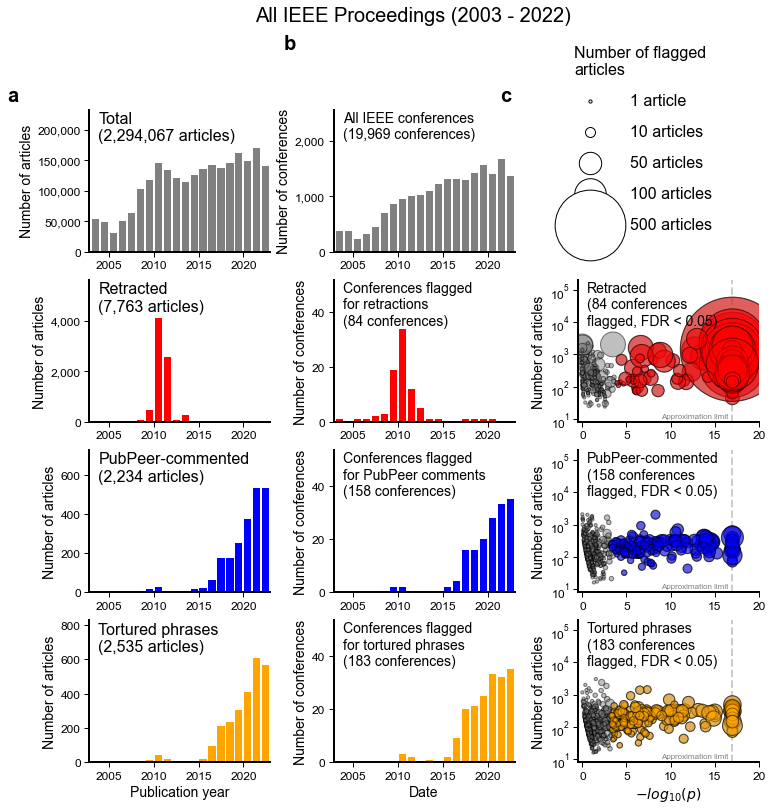

In [11]:
%%time
for source_id in ['ieee']:

    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12,12), gridspec_kw={'hspace':0.2, 'wspace':0.35})

    ### first column: counts
    year_series = p_val_df.groupby('year_x').sum()
    ax = axes[0][0]
    ax.bar(x=year_series.index+0.5, height=year_series['total'], color='gray')
    ax.set_title('Total\n(' + '{:,}'.format(p_val_df['total'].sum()) + ' articles)', 
                     fontsize=16, ha='left', x=0.05, y=0.95, va='top')

    ax = axes[1][0]
    ax.bar(x=year_series.index+0.5, height=year_series['retracted'], color='r')
    ax.set_title('Retracted\n(' + '{:,}'.format(p_val_df['retracted'].sum()) + ' articles)', 
                     fontsize=16, ha='left', x=0.05, y=0.95, va='top')


    ax = axes[2][0]
    ax.bar(x=year_series.index+0.5, height=year_series['pubpeer'], color='b')
    ax.set_title('PubPeer-commented\n(' + '{:,}'.format(p_val_df['pubpeer'].sum()) + ' articles)', 
                     fontsize=16, ha='left', x=0.05, y=0.95, va='top')
    
    ax = axes[3][0]
    ax.bar(x=year_series.index+0.5, height=year_series['tortured'], color='orange')
    ax.set_title('Tortured phrases\n(' + '{:,}'.format(p_val_df['tortured'].sum()) + ' articles)', 
                     fontsize=16, ha='left', x=0.05, y=0.95, va='top')

    for ax in axes[:,0]:
        ax.set_ylim(bottom=0, top=ax.get_ylim()[1]*1.3)
        ax.set_xlim([2003-0.2,2023])
        ax.tick_params(width=1, length=5, which='major')
        ax.tick_params(width=1, length=2, which='minor')
        ax.tick_params(labelsize=12)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        [ax.spines[i].set_linewidth(2) for i in ax.spines]
        ax.get_yaxis().set_major_formatter(
            mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        ax.set_ylabel('Number of articles', fontsize=14)
        
    axes[3][0].set_xlabel('Publication year', fontsize=14)


    ### third column: editor enrichments

    # Retractions
    ax = axes[1][2]
    ax.scatter(-np.log10(p_val_df['retract_p_val']), p_val_df['total'],
                   color='gray', linewidth=1, alpha=0.5, s=10*p_val_df['retracted'], edgecolor='k')
    p_val_df_slice = p_val_df[p_val_df['retract_q_val'] < 0.05].copy()
    ax.scatter(-np.log10(p_val_df_slice['retract_p_val']), p_val_df_slice['total'], 
                   color='r', linewidth=1, alpha=0.5, s=10*p_val_df_slice['retracted'], edgecolor='k')
    ax.set_title('Retracted\n(' + str(len(p_val_df_slice)) + ' conferences\nflagged, FDR < 0.05)', 
                     fontsize=14, ha='left', x=0.05, y=0.95, va='top')

    # PubPeer
    ax = axes[2][2]
    ax.scatter(-np.log10(p_val_df['pubpeer_p_val']), p_val_df['total'],
                   color='gray', linewidth=1, alpha=0.5, s=10*p_val_df['pubpeer'], edgecolor='k')
    p_val_df_slice = p_val_df[p_val_df['pubpeer_q_val'] < 0.05]
    ax.scatter(-np.log10(p_val_df_slice['pubpeer_p_val']), p_val_df_slice['total'], 
                   color='b', linewidth=1, alpha=0.5, s=10*p_val_df_slice['pubpeer'], edgecolor='k')
    ax.set_title('PubPeer-commented\n(' + str(len(p_val_df_slice)) + ' conferences\nflagged, FDR < 0.05)', 
                     fontsize=14, ha='left', x=0.05, y=0.95, va='top')
    
    # Tortured
    ax = axes[3][2]
    ax.scatter(-np.log10(p_val_df['tortured_p_val']), p_val_df['total'],
                   color='gray', linewidth=1, alpha=0.5, s=10*p_val_df['tortured'], edgecolor='k')
    p_val_df_slice = p_val_df[p_val_df['tortured_q_val'] < 0.05]
    ax.scatter(-np.log10(p_val_df_slice['tortured_p_val']), p_val_df_slice['total'],
                   color='orange', linewidth=1, alpha=0.5, s=10*p_val_df_slice['tortured'], edgecolor='k')
    ax.set_title('Tortured phrases\n(' + str(len(p_val_df_slice)) + ' conferences\nflagged, FDR < 0.05)', 
                     fontsize=14, ha='left', x=0.05, y=0.95, va='top')

    # legend
    ax = axes[0][2]
    ax.scatter([], [], s=10, color='w', alpha=1, linewidth=1, edgecolor='k', label='1 article')
    ax.scatter([], [], s=100, color='w', alpha=1, linewidth=1, edgecolor='k', label='10 articles')
    ax.scatter([], [], s=500, color='w', alpha=1, linewidth=1, edgecolor='k', label='50 articles')
    ax.scatter([], [], s=1000, color='w', alpha=1, linewidth=1, edgecolor='k', label='100 articles')
    ax.scatter([], [], s=5000, color='w', alpha=1, linewidth=1, edgecolor='k', label='500 articles')
    #ax.scatter([], [], s=2000, color='w', alpha=1, linewidth=1, edgecolor='k', label='200 retracted/commented')
    leg = ax.legend(fontsize=16, bbox_to_anchor=(-0.1,0.8), 
              loc='center left', frameon=False, labelspacing=1, handletextpad=1.5)
    leg.set_title('Number of flagged\narticles')
    plt.setp(leg.get_title(),fontsize=16, ha='left')
    leg._legend_box.align = 'left'
    ax.axis('off')
    
    axes[3][2].set_xlabel(r'$-log_{10}(p)$', fontsize=14)

    for ax in axes[1:,2]:
        ax.set_yscale('log')
        #ax.set_xlabel(r'$-log_{10}(p)$', fontsize=14)
        ax.set_ylabel('Number of articles', fontsize=14)
        ax.set_ylim([8, 200_000])
        ax.set_xlim([-0.5,20])
        minor_xticks = []
        major_xticks = np.array([10,100,1_000,10_000, 100_000])
        for n in range(1,10):
            minor_xticks.append(n*major_xticks)
        minor_xticks = np.array(minor_xticks).flatten()
        ax.set_yticks(which='major', ticks=major_xticks)
        ax.set_yticks(which='minor', ticks=major_xticks)
        ax.tick_params(width=1, length=5, which='major')
        ax.tick_params(width=1, length=2, which='minor')
        ax.tick_params(labelsize=12)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        [ax.spines[i].set_linewidth(2) for i in ax.spines]
        ax.axvline(17, color='k', linewidth=2, linestyle='dashed', alpha=0.2, zorder=-10)
        ax.text(s='Approximation limit', x=16.5, y=10, fontsize=8, va='bottom', ha='right', color='k', alpha=0.5)

    ### second column: conference counts

    year_series = p_val_df.groupby('year_x').count()
    ax = axes[0][1]
    ax.bar(x=year_series.index+0.5, height=year_series['total'], color='gray')
    ax.set_title('All IEEE conferences\n' + '({:,} conferences)'.format(year_series.sum()['total']),
                 fontsize=14, ha='left', x=0.05, y=0.95, va='top')
    
    ax = axes[1][1]
    year_series = p_val_df[p_val_df['retract_q_val'] < 0.05].groupby('year_x').count()
    ax.bar(x=year_series.index+0.5, height=year_series['total'], color='r')
    ax.set_title('Conferences flagged\nfor retractions\n' + '({:,} conferences)'.format(year_series.sum()['total']),
                 fontsize=14, ha='left', x=0.05, y=0.95, va='top')

    
    ax = axes[2][1]
    year_series = p_val_df[p_val_df['pubpeer_q_val'] < 0.05].groupby('year_x').count()
    ax.bar(x=year_series.index+0.5, height=year_series['pubpeer'], color='b')
    ax.set_title('Conferences flagged\nfor PubPeer comments\n' + '({:,} conferences)'.format(year_series.sum()['total']),
                 fontsize=14, ha='left', x=0.05, y=0.95, va='top')
    
    ax = axes[3][1]
    year_series = p_val_df[p_val_df['tortured_q_val'] < 0.05].groupby('year_x').count()
    ax.bar(x=year_series.index+0.5, height=year_series['tortured'], color='orange')
    ax.set_title('Conferences flagged\nfor tortured phrases\n' + '({:,} conferences)'.format(year_series.sum()['total']),
                 fontsize=14, ha='left', x=0.05, y=0.95, va='top')
        
    axes[3][1].set_xlabel('Date', fontsize=14)
    for ax in axes[:,1]:
        ax.set_ylim(bottom=0)
        ax.tick_params(width=1, length=5, which='major')
        ax.tick_params(width=1, length=2, which='minor')
        ax.tick_params(labelsize=12)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_ylabel('Number of conferences', fontsize=14)
        [ax.spines[i].set_linewidth(2) for i in ax.spines]
        ax.set_ylim(bottom=0, top=ax.get_ylim()[1]*1.45)
        ax.get_yaxis().set_major_formatter(
            mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        ax.set_xlim([2003-0.2,2023])
        
    title = 'All IEEE Proceedings (2003 - 2022)'
        
    #print(title)
        
    fig.suptitle(title, y=1, fontsize=20)
    fig.text(s='a', x=0.03, y=0.89, fontsize=20, weight='bold')
    fig.text(s='b', x=0.35, y=0.95, fontsize=20, weight='bold')
    fig.text(s='c', x=0.6, y=0.89, fontsize=20, weight='bold')
    fig.savefig('../img/250129_' + source_id + '_summary_fig_fdr.png', dpi=200, bbox_inches='tight')

In [44]:
year_series.sum()

conference        183
retract_p_val     183
pubpeer_p_val     183
either_p_val      183
tortured_p_val    183
retract_q_val     183
retract_fwer      183
pubpeer_q_val     183
pubpeer_fwer      183
either_q_val      183
either_fwer       183
tortured_q_val    183
tortured_fwer     183
year_y            183
is_retracted      183
pubmed_id         183
pmc_id            183
retracted         183
pubpeer           183
either            183
tortured          183
total             183
dtype: int64

In [45]:
p_val_df

,conference,retract_p_val,pubpeer_p_val,either_p_val,tortured_p_val,year_x,retract_q_val,retract_fwer,pubpeer_q_val,pubpeer_fwer,...,tortured_fwer,year_y,is_retracted,pubmed_id,pmc_id,retracted,pubpeer,either,tortured,total
0,21cw31760.2014,1.0,1.000,1.000,1.000,2014,1.0,1.0,1.0,1.0,...,1.0,2014.0,0,0.0,0.0,0,0,0,0,1
1,21cw48944.2021,1.0,1.000,1.000,1.000,2021,1.0,1.0,1.0,1.0,...,1.0,56588.0,0,0.0,0.0,0,0,0,0,28
2,3ca16351.2010,1.0,1.000,1.000,1.000,2010,1.0,1.0,1.0,1.0,...,1.0,574860.0,0,0.0,0.0,0,0,0,0,286
3,3d-peim49630.2021,1.0,1.000,1.000,1.000,2021,1.0,1.0,1.0,1.0,...,1.0,14147.0,0,0.0,0.0,0,0,0,0,7
4,3dcve34140.2014,1.0,1.000,1.000,1.000,2014,1.0,1.0,1.0,1.0,...,1.0,14098.0,0,0.0,0.0,0,0,0,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19964,zinc44137.2018,1.0,1.000,1.000,1.000,2018,1.0,1.0,1.0,1.0,...,1.0,90810.0,0,0.0,0.0,0,0,0,0,45
19965,zinc47601.2019,1.0,1.000,1.000,1.000,2019,1.0,1.0,1.0,1.0,...,1.0,64608.0,0,0.0,0.0,0,0,0,0,32
19966,zinc50678.2020,1.0,1.000,1.000,1.000,2020,1.0,1.0,1.0,1.0,...,1.0,149480.0,0,0.0,0.0,0,0,0,0,74
19967,zinc52049.2021,1.0,1.000,1.000,1.000,2021,1.0,1.0,1.0,1.0,...,1.0,119239.0,0,0.0,0.0,0,0,0,0,59


In [46]:
works_df[works_df['doi'].apply(lambda x: x.split('https://doi.org/')[-1]).isin(a)].drop_duplicates('doi')['conference'].astype(str).value_counts()

None                2308
icbbe16175.2011     1084
aimsec19209.2011     446
iccasm17180.2010     441
icams17079.2010      431
                    ... 
itcs14918.2009         1
icassp40776.2020       1
wartia33914.2014       1
icmtma17603.2011       1
ares15227.2009         1
Name: conference, Length: 342, dtype: int64

In [47]:
rw_db['datetime'] = pd.to_datetime(rw_db['OriginalPaperDate'])

In [48]:
rw_db['year'] = [x.year for x in rw_db['datetime']]

In [49]:
rw_slice = rw_db[rw_db['Publisher'] == 'IEEE: Institute of Electrical and Electronics Engineers']

In [50]:
rw_slice[(rw_slice['year'] >= 2010) & (rw_slice['OriginalPaperDOI'].isna())]['RetractionDOI']

36122      10.1109/ICEMMS.2011.6015790
36228      10.1109/ICEMMS.2011.6015811
36473      10.1109/ICBMEI.2011.5920966
36685        10.1109/OPEE.2010.5508032
36686        10.1109/OPEE.2010.5507947
                     ...              
43736    10.1109/IITA-GRS.2010.5602372
43737    10.1109/IITA-GRS.2010.5602219
43738    10.1109/IITA-GRS.2010.5602699
43740    10.1109/IITA-GRS.2010.5602003
43742    10.1109/IITA-GRS.2010.5603259
Name: RetractionDOI, Length: 2182, dtype: object

### Conference series that are compromised?

In [3]:
p_val_df['conference_series'] = p_val_df['conference'].apply(lambda x: re.sub("[0-9]+", "", x))
p_val_df['year'] = p_val_df['conference']

In [4]:
p_val_df['conference_series'].value_counts()

icet.           27
icps.           26
ice.            24
ict.            22
icsc.           21
                ..
moc.             1
mobs.            1
bids.            1
mobiquitous.     1
icevent.         1
Name: conference_series, Length: 5052, dtype: int64

In [5]:
p_val_df[(p_val_df['pubpeer_q_val'] < 0.05) | (p_val_df['tortured_q_val'] < 0.05) | (p_val_df['retract_q_val'] < 0.05)]['conference_series'].value_counts()

i-smac.    6
icoei.     5
iceca.     5
iccmc.     5
icrito.    4
          ..
iccst.     1
icct.      1
icctct.    1
icctd.     1
wocn.      1
Name: conference_series, Length: 193, dtype: int64

In [6]:
p_val_df['suspect'] = (p_val_df['pubpeer_q_val'] < 0.05) | (p_val_df['tortured_q_val'] < 0.05) | (p_val_df['retract_q_val'] < 0.05)

In [7]:
p_val_df['pubpeer_flagged'] = (p_val_df['pubpeer_q_val'] < 0.05)
p_val_df['tortured_flagged'] = (p_val_df['tortured_q_val'] < 0.05)
p_val_df['retract_flagged'] = (p_val_df['retract_q_val'] < 0.05)

In [11]:
p_val_df[p_val_df['tortured_flagged']]

,conference,retract_p_val,pubpeer_p_val,either_p_val,tortured_p_val,year_x,retract_q_val,retract_fwer,pubpeer_q_val,pubpeer_fwer,...,pubpeer,either,tortured,total,conference_series,year,suspect,pubpeer_flagged,tortured_flagged,retract_flagged
78,accai53970.2022,1.0,1.027e-04,1.027e-04,1.378e-04,2022,1.0,1.0,1.404e-02,1.000e+00,...,6,6,6,192,accai.,accai53970.2022,True,True,True,False
244,aeeicb40393.2017,1.0,4.531e-07,1.018e-06,1.117e-06,2017,1.0,1.0,8.377e-05,9.047e-03,...,5,5,5,114,aeeicb.,aeeicb40393.2017,True,True,True,False
245,aeeicb43271.2018,1.0,8.856e-02,1.021e-01,9.094e-06,2018,1.0,1.0,1.000e+00,1.000e+00,...,1,1,4,78,aeeicb.,aeeicb43271.2018,True,False,True,False
341,aicai45948.2019,1.0,7.945e-07,9.720e-07,2.369e-06,2019,1.0,1.0,1.417e-04,1.587e-02,...,6,6,6,195,aicai.,aicai45948.2019,True,True,True,False
2522,cisct46613.2019,1.0,4.195e-03,4.490e-03,2.236e-04,2019,1.0,1.0,4.480e-01,1.000e+00,...,2,2,3,61,cisct.,cisct46613.2019,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17078,sceecs48394.2020,1.0,3.807e-03,4.064e-03,3.901e-04,2020,1.0,1.0,4.109e-01,1.000e+00,...,3,3,4,122,sceecs.,sceecs48394.2020,True,False,True,False
17776,smart52563.2021,1.0,4.219e-15,1.000e-17,1.000e-17,2021,1.0,1.0,3.088e-12,8.425e-11,...,16,16,16,147,smart.,smart52563.2021,True,True,True,False
17795,smartgencon51891.2021,1.0,6.969e-07,7.504e-07,1.603e-06,2021,1.0,1.0,1.265e-04,1.392e-02,...,7,7,7,154,smartgencon.,smartgencon51891.2021,True,True,True,False
19041,vitecon45748.2019,1.0,8.584e-08,1.086e-07,3.069e-07,2019,1.0,1.0,1.824e-05,1.714e-03,...,7,7,7,224,vitecon.,vitecon45748.2019,True,True,True,False


In [8]:
flag = 'suspect'
img = p_val_df.groupby(['conference_series', 'year_x']).max()[[flag]].reset_index().pivot(index='conference_series', columns='year_x', values=flag)

In [9]:
index = p_val_df[p_val_df[flag]]['conference_series'].value_counts().head(60).index

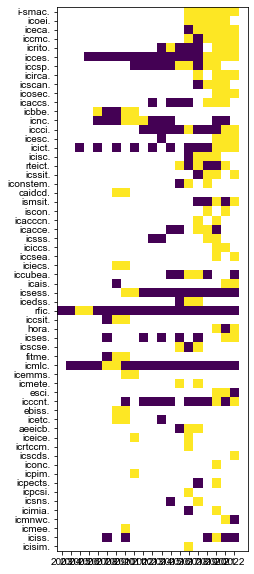

In [10]:
plt.figure(figsize=(10,10))
ax = plt.gca()

plt.imshow(img.loc[index].astype(float))
yticks = ax.set_yticks(np.arange(60), index)
xticks = ax.set_xticks(np.arange(0,20), np.arange(2003,2023))

# Figure S15

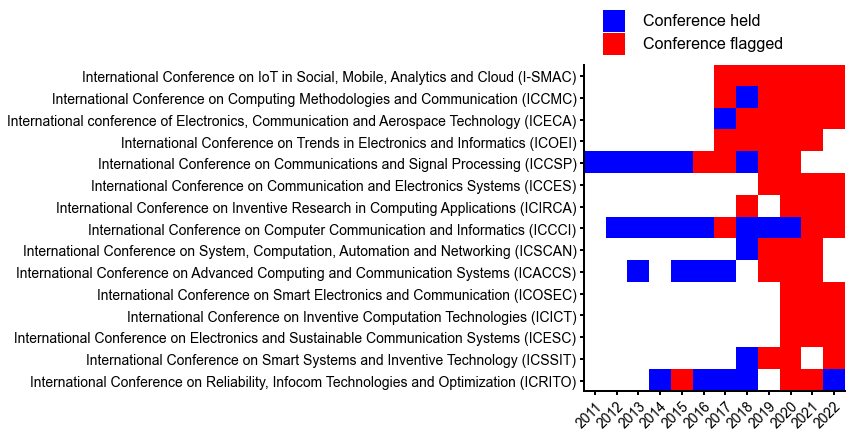

In [250]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6), gridspec_kw={'hspace':0.3})
n_to_show = 15

# conferences with the same names
exclude = ['icnc47757.2020', 'icnc52316.2021', 'icces11603.2006', 'icces12652.2007', 'icces14026.2008',
       'icces15835.2009', 'icces16968.2010', 'icces18937.2011',
       'icces20689.2012', 'icces31349.2013', 'icces34237.2014',
       'icces36596.2015', 'icces39926.2016', 'icces42632.2017',
       'icces44230.2018', 'icces48960.2019', 'icces51560.2020',
       'icces54031.2021', 'iccci51764.2021', 'iccci55554.2022', 'icict11087.2005', 'icict12027.2007', 'icict15846.2009',
       'icict19054.2011', 'icict33034.2013', 'icict37298.2015',
       'icict42700.2017', 'icict43934.2018', 'icict46931.2019',
       'icict47744.2019', 'icict50521.2020', 'icict52195.2021',
       'icict52872.2021', 'icict55905.2022', 'icesc31486.2014']
# convert conference codes to names
name_map = {'i-smac.': 'International Conference on IoT in Social, Mobile, Analytics and Cloud (I-SMAC)',
           'iccmc.':' International Conference on Computing Methodologies and Communication (ICCMC)',
           'iceca.':'International conference of Electronics, Communication and Aerospace Technology (ICECA)', 
            'icoei.':' International Conference on Trends in Electronics and Informatics (ICOEI)', 
            'iccsp.': 'International Conference on Communications and Signal Processing (ICCSP)', 
            'icces.' : 'International Conference on Communication and Electronics Systems (ICCES)', 
            'icirca.': 'International Conference on Inventive Research in Computing Applications (ICIRCA)',
           'iccci.': 'International Conference on Computer Communication and Informatics (ICCCI)', 
           'icscan.': 'International Conference on System, Computation, Automation and Networking (ICSCAN)', 
            'icaccs.':'International Conference on Advanced Computing and Communication Systems (ICACCS)', 
            'icosec.':'International Conference on Smart Electronics and Communication (ICOSEC)', 
            'icict.':'International Conference on Inventive Computation Technologies (ICICT)', 
            'icesc.':' International Conference on Electronics and Sustainable Communication Systems (ICESC)', 
            'icssit.':'International Conference on Smart Systems and Inventive Technology (ICSSIT)',
            'icrito.':'International Conference on Reliability, Infocom Technologies and Optimization (ICRITO)',
            'icccnt.':'International Conference on Computing Communication and Networking Technology (ICCCNT)',
            'icsss.': 'International Conference on Smart Structures and Systems (ICSSS)',
            'icedss.':'Conference on Emerging Devices and Smart Systems (ICEDSS)',
            'aeeicb.':'International Conference on Advances in Electrical, Electronics, Information, Communication and Bio-Informatics (AEEICB)',
           'icmete.':'International Conference on Micro-Electronics and Telecommunication Engineering (ICMETE)'
           }

for flag in ['tortured_flagged']:
    img = p_val_df[~p_val_df['conference'].isin(exclude)].groupby(['conference_series', 'year_x']).max()[[flag]].reset_index().pivot(index='conference_series', columns='year_x', values=flag)
    index = img.sum(axis=1).sort_values(ascending=False).head(n_to_show).index
    names = [name_map.get(x) for x in index]
    ax.imshow(img.loc[index].astype(float), cmap='bwr')
    
    yticks = ax.set_yticks(np.arange(n_to_show), names)
    xticks = ax.set_xticks(np.arange(0,20))
    ax.set_xticklabels(np.arange(2003,2023), rotation=45, 
                       ha='right', rotation_mode='anchor', 
                       fontsize=14)
    ax.set_xlim([7.5,19.5])
    
    [ax.spines[i].set_linewidth(2) for i in ax.spines]
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(width=2, length=4, which='major')
    ax.tick_params(width=2, length=2, which='minor')
    ax.tick_params(labelsize=14)
    
ax.scatter([], [], color='blue', linewidth=0, label='Conference held', marker='s', s=500)
ax.scatter([], [], color='red', linewidth=0, label='Conference flagged', marker='s', s=500)
ax.legend(frameon=False, bbox_to_anchor=(0,1), loc='lower left', fontsize=16)

fig.savefig('../img/250105_ieee_conference_tortured_flagged_series.png', dpi=200, bbox_inches='tight')

In [249]:
p_val_df[~p_val_df['conference'].isin(exclude) & p_val_df['conference_series'].isin(index)]['tortured'].sum()

713

In [229]:
[name_map.get(x) for x in index]

['International Conference on IoT in Social, Mobile, Analytics and Cloud (I-SMAC)',
 ' International Conference on Computing Methodologies and Communication (ICCMC)',
 'International conference of Electronics, Communication and Aerospace Technology (ICECA)',
 ' International Conference on Trends in Electronics and Informatics (ICOEI)',
 'International Conference on Communications and Signal Processing (ICCSP)',
 'International Conference on Communication and Electronics Systems (ICCES)',
 'International Conference on Inventive Research in Computing Applications (ICIRCA)',
 'International Conference on Computer Communication and Informatics (ICCCI)',
 'International Conference on System, Computation, Automation and Networking (ICSCAN)',
 'International Conference on Advanced Computing and Communication Systems (ICACCS)',
 'International Conference on Smart Electronics and Communication (ICOSEC)',
 'International Conference on Inventive Computation Technologies (ICICT)',
 ' International

In [150]:
img.sum(axis=1).sort_values(ascending=False).head(n_to_show).index

Index(['i-smac.', 'iccmc.', 'iceca.', 'icoei.', 'iccsp.', 'icces.', 'icirca.',
       'iccci.', 'icscan.', 'icaccs.'],
      dtype='object', name='conference_series')

In [206]:
p_val_df[(p_val_df['conference_series'] == 'icict.') & 
         ~p_val_df['tortured_flagged'] & 
         ~p_val_df['conference'].isin(['icict43934', 'icict38698'])]['conference'].values

array(['icict11087.2005', 'icict12027.2007', 'icict15846.2009',
       'icict19054.2011', 'icict33034.2013', 'icict37298.2015',
       'icict42700.2017', 'icict43934.2018', 'icict46931.2019',
       'icict47744.2019', 'icict50521.2020', 'icict52195.2021',
       'icict52872.2021', 'icict55905.2022'], dtype=object)

In [218]:
p_val_df[p_val_df['conference_series'] == 'icmete.']

,conference,retract_p_val,pubpeer_p_val,either_p_val,tortured_p_val,year_x,retract_q_val,retract_fwer,pubpeer_q_val,pubpeer_fwer,...,pubpeer,either,tortured,total,conference_series,year,suspect,pubpeer_flagged,tortured_flagged,retract_flagged
9085,icmete38202.2016,1.0,4.382e-09,9.187e-09,3.253e-08,2016,1.0,1.0,1.151e-06,8.750e-05,...,5,5,5,130,icmete.,icmete38202.2016,True,True,True,False
9086,icmete43082.2018,1.0,1.000e+00,1.000e+00,6.251e-06,2018,1.0,1.0,1.000e+00,1.000e+00,...,0,0,4,71,icmete.,icmete43082.2018,True,False,True,False


In [106]:
p_val_df[p_val_df['conference_series'].isin(index)].pivot()

,conference,retract_p_val,pubpeer_p_val,either_p_val,tortured_p_val,year_x,retract_q_val,retract_fwer,pubpeer_q_val,pubpeer_fwer,...,pubpeer,either,tortured,total,conference_series,year,suspect,pubpeer_flagged,tortured_flagged,retract_flagged
6122,i-smac39767.2017,1.0,3.553e-09,1.100e-08,1.251e-08,2017,1.0,1.0,9.460e-07,7.095e-05,...,7,7,7,171,i-smac.,i-smac39767.2017,True,True,True,False
6123,i-smac43168.2018,1.0,5.440e-15,2.875e-14,2.884e-10,2018,1.0,1.0,3.746e-12,1.086e-10,...,10,10,8,156,i-smac.,i-smac43168.2018,True,True,True,False
6124,i-smac47947.2019,1.0,1.000e-17,1.000e-17,1.000e-17,2019,1.0,1.0,1.051e-14,1.997e-13,...,17,17,15,153,i-smac.,i-smac47947.2019,True,True,True,False
6125,i-smac49090.2020,1.0,4.297e-14,6.184e-14,8.882e-16,2020,1.0,1.0,2.200e-11,8.580e-10,...,13,13,15,225,i-smac.,i-smac49090.2020,True,True,True,False
6126,i-smac52330.2021,1.0,2.888e-11,3.307e-11,1.337e-10,2021,1.0,1.0,9.945e-09,5.768e-07,...,13,13,13,305,i-smac.,i-smac52330.2021,True,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9849,icrito41188.2017,1.0,1.000e+00,1.000e+00,1.819e-01,2017,1.0,1.0,1.000e+00,1.000e+00,...,0,0,1,130,icrito.,icrito41188.2017,False,False,False,False
9850,icrito43735.2018,1.0,1.000e+00,1.000e+00,2.312e-02,2018,1.0,1.0,1.000e+00,1.000e+00,...,0,0,2,143,icrito.,icrito43735.2018,False,False,False,False
9851,icrito48877.2020,1.0,2.901e-09,3.619e-09,9.056e-08,2020,1.0,1.0,7.829e-07,5.794e-05,...,10,10,9,271,icrito.,icrito48877.2020,True,True,True,False
9852,icrito51393.2021,1.0,9.437e-15,1.000e-17,1.000e-17,2021,1.0,1.0,5.543e-12,1.884e-10,...,19,19,24,399,icrito.,icrito51393.2021,True,True,True,False


In [158]:
ieee_works

NameError: name 'ieee_works' is not defined